In [1]:
%matplotlib inline

import datetime
import functools
from itertools import izip
import os
from IPython.core.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy.stats
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from clipper.src import CLIP_analysis
from gscripts import qtools
from gscripts.encode import encode_helpers
from gscripts.general import dataviz
from gscripts.rnaseq import splicing_map

tqdm.pandas(desc="Progress")
sns.set_style("ticks")
img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2/"

xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))
xfmt_int = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x) / 1000000, ','))


In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

matplotlib.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
merged_data = encode_helpers.get_merged_data()

#Filter out anything sequenced after 16/7/18
merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]

# merge rmRep Counts

In [4]:
#Get all the counts
counts_list = pd.read_csv("downsample_counts_full_v4.csv", dtype={"RBP_ID": str, "bio_rep": str, "tech_rep": str})
counts_list = counts_list.set_index(["RBP_ID", "RBP", "bio_rep", "tech_rep", "fraction"])
counts_list = counts_list.xs(1.0, level="fraction").groupby(level=['RBP_ID', "RBP", "bio_rep"]).sum()
counts_list.index.rename(["uID", "RBP", "bio_rep"], inplace=True)
counts_list['rep'] = ["rep1" if rep == "01" else "rep2" for rep in counts_list.index.get_level_values(level="bio_rep")]
counts_list.index = counts_list.index.droplevel("bio_rep")
counts_list = counts_list.set_index("rep", append=True)

In [5]:
#Double check all my merging is correct
print len(set(merged_data.index.get_level_values(level=0)) - set(counts_list.index.get_level_values(level=0)))
print len(set(counts_list.index.get_level_values(level=0)) - set(merged_data.index.get_level_values(level=0)))
print len(set(counts_list.index.get_level_values(level=0)) & set(merged_data.index.get_level_values(level=0)))

0
0
327


In [6]:
# Total Datasets we care about
len(merged_data), len(counts_list)

(654, 654)

In [7]:
merged_data['Cell line'] = merged_data.index.get_level_values(level="Cell line")
merged_data.index = merged_data.index.droplevel("Cell line")

merged_data['RBP'] = merged_data.index.get_level_values(level="RBP")
merged_data.index = merged_data.index.droplevel("RBP")

counts_list['RBP'] = counts_list.index.get_level_values(level="RBP")
counts_list.index = counts_list.index.droplevel("RBP")

merged_data = pd.merge(merged_data, counts_list,
        left_index=True, right_index=True, how="left")

merged_data = merged_data.drop("RBP_y", axis=1)
merged_data = merged_data.rename(columns={"RBP_x": "RBP"})

merged_data = merged_data.set_index("RBP", append=True)
merged_data = merged_data.swaplevel("rep", "RBP")

merged_data = merged_data.set_index("Cell line", append=True)
merged_data = merged_data.swaplevel("rep", "Cell line")

In [8]:
print "number of datasets without reads merged"
print len(merged_data[merged_data.directional.isnull()])

number of datasets without reads merged
0


In [9]:
final_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_master_qc.csv")
final_qc_frame = final_qc_frame.fillna("")
final_qc_frame['Reads Written Round 2'] = final_qc_frame['Reads Written Round 2'].astype(int)
final_qc_frame = final_qc_frame.set_index(keys=["rbp", "encode_id", "rep", "cell_type", "full_name", "barcode"])
filtered_final_qc_frame = final_qc_frame[[ "Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Uniquely mapped reads %", 'Number of reads mapped to too many loci',
                                          '% of reads unmapped: too short', '% of reads mapped to too many loci', "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks", "Reads Written Round 2"]]

grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
grouped_final_qc_frame = grouped_final_qc_frame.dropna()
grouped_final_qc_frame['full_name'] = grouped_final_qc_frame.index.get_level_values(level="full_name")


In [10]:
#Make sure we can join input counts
fn_label_map = pd.read_table("/home/gpratt/projects/encode/scripts/encode_GRCh38_v1.txt", header=None,
              names=['fn', 'species', 'label', 'foo', 'bar', 'baz', 'biz'])
fn_label_map['fn_basename'] = fn_label_map.fn.apply(lambda x: os.path.basename(x.split(";")[0]).split(".")[0])
fn_label_map['label'] = fn_label_map.label.apply(lambda x: "_".join(x.split("_")[:-1]))

#Need to set the full name of the inputs to the actual name of the file, sadly I'm going to do this badly
inputs = grouped_final_qc_frame.xs("INPUT", level="rep")    
inputs = pd.merge(inputs, fn_label_map,
         left_on="full_name", right_on="label")

In [11]:
#Remake full name so I can merge this on the merged data
new_full_name = []
for name, row in grouped_final_qc_frame.iterrows():
    #print name, row
    name = inputs[inputs.label == row.full_name]
    if len(name) == 1:
        new_full_name.append(name.iloc[0].fn_basename)
    elif len(name) == 0:
        new_full_name.append(row.full_name)
    else:
        new_full_name.append(np.nan)
        print "error", row.full_name
grouped_final_qc_frame['full_file_name'] = new_full_name

error LNG8-M_INPUT_A04F05
error LNG8-S_INPUT_C01D08
error LNG12-N_INPUT_A04F05
error LNG10-M_INPUT_A04F05
error LNG10-S_INPUT_C01D08
error LNG11-M_INPUT_A04F05
error LNG11-S_INPUT_C01D08
error LNG9-M_INPUT_A04F05
error LNG9-S_INPUT_C01D08


In [12]:
merged_data['full_name'] = merged_data.CLIP.apply(lambda x: "_".join(os.path.basename(x).split("_")[:-1]))
merged_data = merged_data.reset_index()

merged_data = pd.merge(merged_data, grouped_final_qc_frame, 
               left_on="full_name", right_on="full_name", 
               how="left")

# Read Loss Calculations

In [13]:
loss_rate = pd.concat({"family mapped": ((merged_data['uncollapsed']) / merged_data['Input Reads']).dropna(),
"genomic mapped": merged_data['Uniquely Mapped Reads'] / merged_data['Input Reads']}, names=["map_style", "uID"])
loss_rate = loss_rate.reset_index()
loss_rate['fraction_lost'] = 1 - loss_rate[0] 
loss_rate['fraction_retained'] = loss_rate[0] 

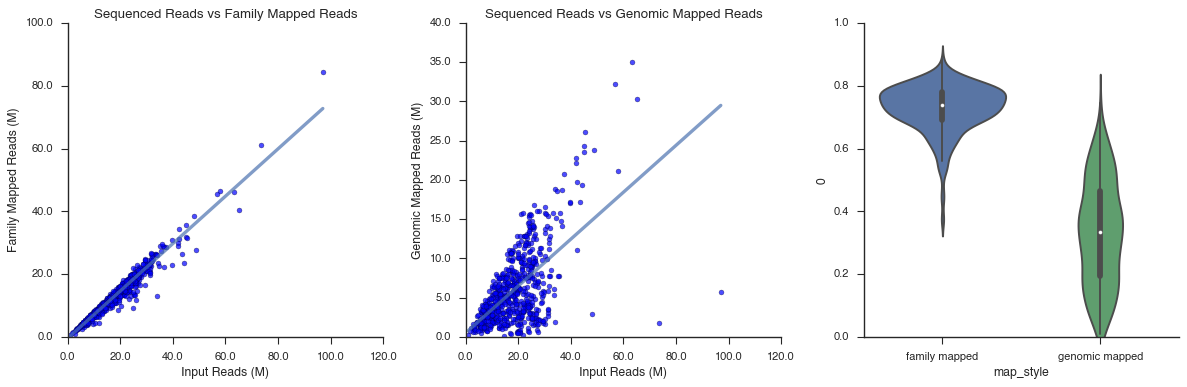

In [14]:
num_rows = 1 
num_cols = 3 
with dataviz.Figure(os.path.join(img_dir, "read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['uncollapsed'], alpha=".7", label="")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Input Reads (M)")
    ax.set_ylabel("Family Mapped Reads (M)")
    ax.set_title("Sequenced Reads vs Family Mapped Reads")
    sns.despine(ax=ax)
    ax.set_ylim(0)
    ax.set_xlim(0)
    
    linregress_family = scipy.stats.linregress(merged_data['Input Reads'], merged_data['uncollapsed'])

    #ax.text(.9, .9, "$R^2 {:.2}$".format(r2), transform=ax.transAxes)
    fit = np.poly1d([linregress_family.slope, linregress_family.intercept])
    ax.plot([min(merged_data['Input Reads']), max(merged_data['Input Reads'])],
            [fit(min(merged_data['Input Reads'])), fit(max(merged_data['Input Reads']))],
           linewidth=3, alpha=.7, label="Regression")


    ax = fig.add_subplot(num_rows,num_cols,2)
    ax.scatter(merged_data['Input Reads'], merged_data['Uniquely Mapped Reads'], alpha=".7", label="")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Input Reads (M)")
    ax.set_ylabel("Genomic Mapped Reads (M)")
    ax.set_title("Sequenced Reads vs Genomic Mapped Reads")
    sns.despine(ax=ax)
    ax.set_ylim(0)
    ax.set_xlim(0)
    foo = merged_data.dropna(subset=['Input Reads', 'Uniquely Mapped Reads'])
    linregress_genomic = scipy.stats.linregress(foo['Input Reads'], foo['Uniquely Mapped Reads'])
    
    #ax.text(.9, .9, "$R^2 {:.2}$".format(r2), transform=ax.transAxes)
    fit = np.poly1d([linregress_genomic.slope, linregress_genomic.intercept])
    ax.plot([min(merged_data['Input Reads']), max(merged_data['Input Reads'])],
            [fit(min(merged_data['Input Reads'])), fit(max(merged_data['Input Reads']))],
           linewidth=3, alpha=.7, label="Regression")

    ax = fig.add_subplot(num_rows,num_cols,3)

    sns.violinplot(y=0, x="map_style", data=loss_rate, ax=ax, orient='v')
    sns.despine(ax=ax)
    ax.set_ylim(0,1)


In [15]:
merged_data['unique_family_mapped_reads'] = merged_data['unique'] - merged_data['Usable Reads']
merged_data['fraction_repetitive'] = np.log2(merged_data['Usable Reads'] / merged_data['unique_family_mapped_reads'])

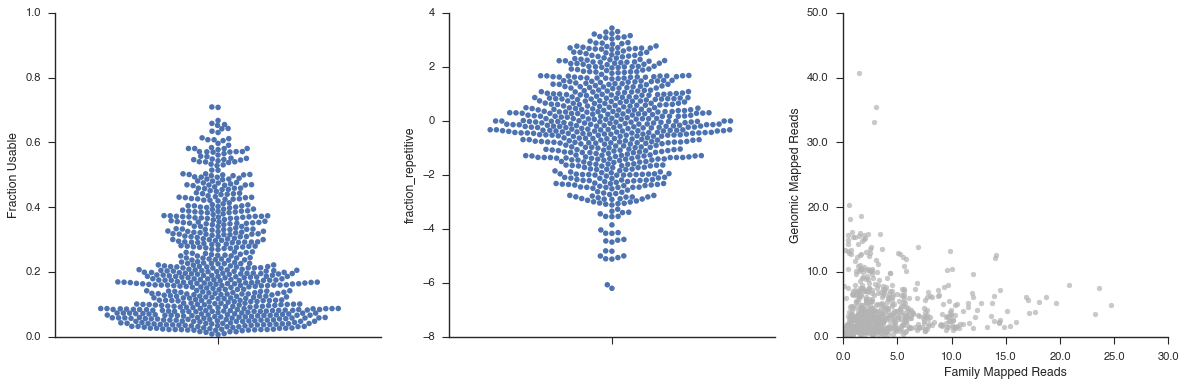

In [16]:
num_rows = 1 
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    sns.swarmplot(merged_data['Fraction Usable'], orient='v', ax=ax)
    ax.set_ylim(0, 1)
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    sns.swarmplot(merged_data['fraction_repetitive'], orient='v', ax=ax)
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(num_rows,num_cols,3)
    ax.scatter(merged_data['Usable Reads'], merged_data['unique_family_mapped_reads'], alpha=".7", color=".7")
    sns.despine(ax=ax)
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel("Family Mapped Reads")
    ax.set_ylabel("Genomic Mapped Reads")

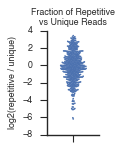

In [17]:
num_rows = 1 
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "fraction_repetitive.svg"), figsize=(1.5 * num_cols,2.0 *num_rows)) as fig:
    
    ax = fig.add_subplot(num_rows,num_cols,1)
    sns.swarmplot(merged_data['fraction_repetitive'], orient='v', size=1.5, linewidth=0, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("log2(repetitive / unique)", fontsize=8)
    ax.set_title("Fraction of Repetitive\nvs Unique Reads", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


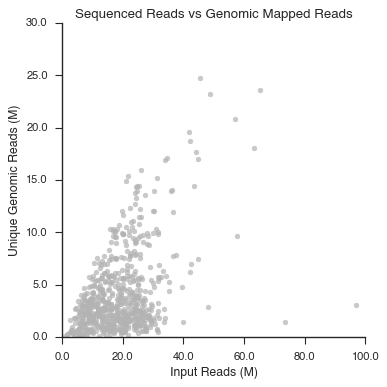

In [18]:
num_rows = 1 
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['Usable Reads'], alpha=".7", color=".7")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Input Reads (M)")
    ax.set_ylabel("Unique Genomic Reads (M)")
    ax.set_title("Sequenced Reads vs Genomic Mapped Reads")
    sns.despine(ax=ax)
    ax.set_ylim(0, 30000000)
    ax.set_xlim(0, 100000000)
    
    #linregress_genomic = scipy.stats.linregress(merged_data['Input Reads'], merged_data['Usable Reads'])
    
    #ax.text(.9, .9, "$R^2 {:.2}$".format(r2), transform=ax.transAxes)
#     fit = np.poly1d([linregress_genomic.slope, linregress_genomic.intercept])
#     ax.plot([min(merged_data['Input Reads']), max(merged_data['Input Reads'])],
#             [fit(min(merged_data['Input Reads'])), fit(max(merged_data['Input Reads']))],
#            linewidth=3, alpha=.7, label="Regression")

In [19]:
linregress_genomic

LinregressResult(slope=0.29879319130097831, intercept=510902.93037018273, rvalue=0.61323359930144483, pvalue=8.3854053336080672e-69, stderr=0.015072800665180398)

In [20]:
family_loss_rate = loss_rate[loss_rate.map_style == "family mapped"]

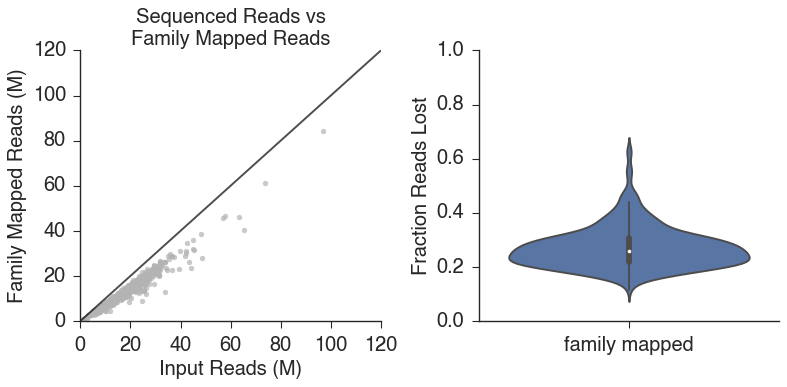

In [21]:
num_rows = 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "total_dropout_rate_plot.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['uncollapsed'], alpha=".7", label="", color=".7")
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Input Reads (M)", fontsize=18)
    ax.set_ylabel("Family Mapped Reads (M)", fontsize=18)
    ax.set_title("Sequenced Reads vs\nFamily Mapped Reads", fontsize=18)
    sns.despine(ax=ax)
    ax.set_ylim(0, 120000000)
    ax.set_xlim(0, 120000000)
#     ax.set_aspect("equal")
#     linregress_family = scipy.stats.linregress(merged_data['Input Reads'], merged_data['uncollapsed'])

#     ax.text(.9, .9, "$R^2 {:.2}$".format(np.power(linregress_family.rvalue, 2)), transform=ax.transAxes, fontsize=16)
#     fit = np.poly1d([linregress_family.slope, linregress_family.intercept])
#     ax.plot([min(merged_data['Input Reads']), max(merged_data['Input Reads'])],
#             [fit(min(merged_data['Input Reads'])), fit(max(merged_data['Input Reads']))],
#            linewidth=3, alpha=.7, label="Regression")
    ax.plot([0,120000000], [0, 120000000], alpha=.7, color=".01")
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax = fig.add_subplot(num_rows,num_cols,2)
    sns.violinplot(y='fraction_lost', x="map_style", data=family_loss_rate, ax=ax, orient='v')
    ax.set_ylabel("Fraction Reads Lost", fontsize=18)
    ax.set_xlabel("")
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]


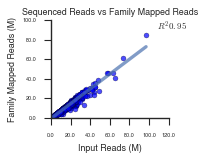

In [22]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "total_dropout_rate.svg"), figsize=(2.5 * num_cols, 2.5*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['uncollapsed'], alpha=".7", label="")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Input Reads (M)", fontsize=8)
    ax.set_ylabel("Family Mapped Reads (M)", fontsize=8)
    ax.set_title("Sequenced Reads vs Family Mapped Reads", fontsize=8)
    sns.despine(ax=ax)
    ax.set_ylim(0)
    ax.set_xlim(0)
    ax.set_aspect("equal")
    linregress_family = scipy.stats.linregress(merged_data['Input Reads'], merged_data['uncollapsed'])

    ax.text(.9, .9, "$R^2 {:.2}$".format(np.power(linregress_family.rvalue, 2)), transform=ax.transAxes, fontsize=8)
    fit = np.poly1d([linregress_family.slope, linregress_family.intercept])
    ax.plot([min(merged_data['Input Reads']), max(merged_data['Input Reads'])],
            [fit(min(merged_data['Input Reads'])), fit(max(merged_data['Input Reads']))],
           linewidth=3, alpha=.7, label="Regression")
    
    [tick.set_fontsize(5) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(5) for tick in ax.get_yticklabels()]

            

In [23]:
print loss_rate[loss_rate.map_style == 'genomic mapped'][0].mean()
print loss_rate[loss_rate.map_style == 'genomic mapped'][0].var()

0.333677469265
0.0277439869799


In [24]:
print loss_rate[loss_rate.map_style == 'family mapped']['fraction_retained'].mean()
print loss_rate[loss_rate.map_style == 'family mapped']['fraction_retained'].var()

0.727717409015
0.00590845366204


In [25]:
print loss_rate[loss_rate.map_style == 'family mapped'][0].mean()
print loss_rate[loss_rate.map_style == 'family mapped'][0].var()

0.727717409015
0.00590845366204


In [26]:
trim_loss_rate = 1- (merged_data['Reads Written Round 2'] / merged_data['Input Reads'])

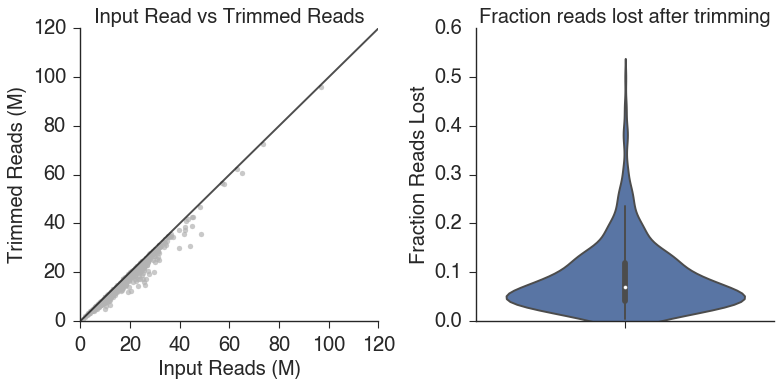

In [27]:
num_rows = 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "trimmed_read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['Reads Written Round 2'], alpha=".7", color=".7")
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Input Reads (M)", fontsize=18)
    ax.set_ylabel("Trimmed Reads (M)", fontsize=18)
    ax.set_title("Input Read vs Trimmed Reads", fontsize=18)
    ax.plot([0,120000000], [0, 120000000], alpha=.7, color=".01")

    sns.despine(ax=ax)
    ax.set_ylim(0, 120000000)
    ax.set_xlim(0, 120000000)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax = fig.add_subplot(num_rows,num_cols,2)

    sns.violinplot(y=trim_loss_rate, ax=ax, orient='v')
    ax.set_title("Fraction reads lost after trimming", fontsize=18)
    ax.set_ylabel("Fraction Reads Lost", fontsize=18)
    sns.despine(ax=ax)
    ax.set_ylim(0,.6)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]


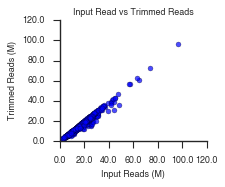

In [28]:
num_rows = 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "read_dropout_rate_pub.svg"), figsize=(2.5 * num_cols,2.5 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Input Reads'], merged_data['Reads Written Round 2'], alpha=.7, label="")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Input Reads (M)", fontsize=8)
    ax.set_ylabel("Trimmed Reads (M)", fontsize=8)
    ax.set_title("Input Read vs Trimmed Reads", fontsize=8)
    sns.despine(ax=ax)
    ax.set_ylim(0)
    ax.set_xlim(0)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


In [29]:
print trim_loss_rate.mean()
print trim_loss_rate.var()

0.0898495206019
0.00504463336417


In [30]:
map_loss_rate = 1 - ((merged_data['uncollapsed']) / merged_data['Reads Written Round 2'])

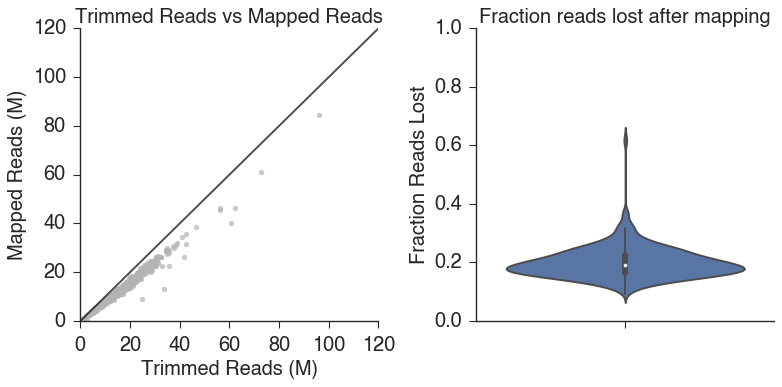

In [31]:

num_rows = 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "mapped_read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Reads Written Round 2'], merged_data['uncollapsed'], alpha=".7", color=".7")
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_ylabel("Mapped Reads (M)", fontsize=18)
    ax.set_xlabel("Trimmed Reads (M)", fontsize=18)
    ax.set_title("Trimmed Reads vs Mapped Reads", fontsize=18)
    ax.plot([0,120000000], [0, 120000000], alpha=.7, color=".01")
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)
    ax.set_ylim(0, 120000000)
    ax.set_xlim(0, 120000000)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    sns.violinplot(y=map_loss_rate, ax=ax, orient='v')
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    ax.set_title("Fraction reads lost after mapping", fontsize=18)
    ax.set_ylabel("Fraction Reads Lost", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]


In [32]:
print map_loss_rate.mean()
print map_loss_rate.var()

0.200542774317
0.00304624957828


Wow, Family mapping really does make the loss between mapped reads and sequenced reads linear.  Thats great.  I can calculate a loss value using a simple linear regression  here

In [33]:
loss_number = loss_rate[loss_rate.map_style == "family mapped"][0].mean()

In [34]:
1 - loss_number

0.27228259098476915

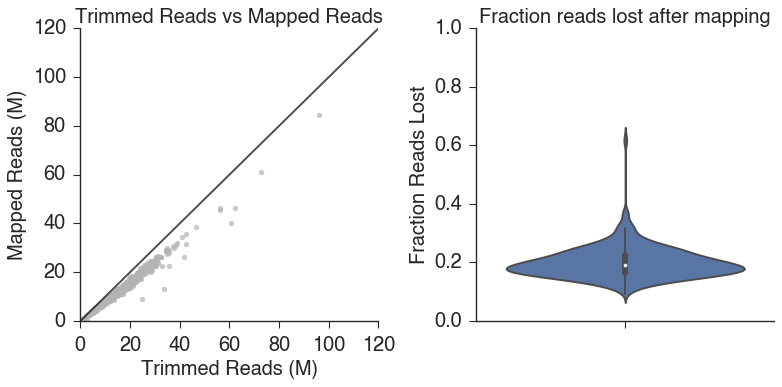

In [35]:
xfmt_int = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x) / 1000000, ','))

num_rows = 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "mapped_read_dropout_rate.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(merged_data['Reads Written Round 2'], merged_data['uncollapsed'], alpha=".7", color=".7")
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_ylabel("Mapped Reads (M)", fontsize=18)
    ax.set_xlabel("Trimmed Reads (M)", fontsize=18)
    ax.set_title("Trimmed Reads vs Mapped Reads", fontsize=18)
    ax.plot([0,120000000], [0, 120000000], alpha=.7, color=".01")
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)
    ax.set_ylim(0, 120000000)
    ax.set_xlim(0, 120000000)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    sns.violinplot(y=map_loss_rate, ax=ax, orient='v')
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    ax.set_title("Fraction reads lost after mapping", fontsize=18)
    ax.set_ylabel("Fraction Reads Lost", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]


# This number is important 
Its the mean loss value across all my datasets
Mean loss value is .73

In [36]:
print linregress_family
print linregress_genomic

LinregressResult(slope=0.75443733639763588, intercept=-433923.93054316007, rvalue=0.97399171250474614, pvalue=0.0, stderr=0.0068734163993980834)
LinregressResult(slope=0.29879319130097831, intercept=510902.93037018273, rvalue=0.61323359930144483, pvalue=8.3854053336080672e-69, stderr=0.015072800665180398)


# Get Input Reads

In [37]:
input_names = grouped_final_qc_frame.set_index("full_file_name")
merged_data['input_file_name'] = merged_data.INPUT.apply(lambda x: os.path.basename(x).split(".")[0])
merged_data['input_usable'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['Usable Reads'])
merged_data['input_name'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['full_name'])

# Get Erics rmduped input reads

In [38]:
eric_reads = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/ENCODE_20170429_newannotations_FINAL.readnumbers.csv",
             names=["uID", "rep", "full_name", "same", "input_reads_name", "input_reads", "usable_name", "usable", 
              "unique_genome_nonrep_name", "unique_genome_nonrep"])
eric_reads = eric_reads.drop(["usable_name", "unique_genome_nonrep_name", "input_reads_name", "same"],axis=1)
eric_reads['uid'] = eric_reads.full_name.apply(lambda x: "_".join(x.split("_")[:-1]))
eric_reads = eric_reads.set_index("uid")

merged_data['family_map_input_usable'] = merged_data['input_name'].apply(lambda x: eric_reads.ix[x]['input_reads'])

eric_subset = eric_reads[['input_reads', 'usable', 'unique_genome_nonrep']]
merged_data = pd.merge(merged_data, eric_subset, left_on='full_file_name', right_index=True, how="left")

In [39]:
foo = pd.merge(grouped_final_qc_frame, eric_subset, left_on="full_name", right_index=True, how="right")

In [40]:
input_reads = foo.xs("INPUT", level="rep")

# Update low read number based on family mapping + fscore trick

In [41]:
under_sequenced_data = merged_data[merged_data['Usable Reads'] < 1000000]
under_sequenced_data = under_sequenced_data.copy()

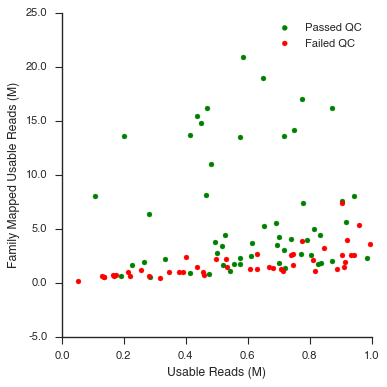

In [42]:
num_rows = 1 
num_cols = 1 
xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))


with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.scatter(under_sequenced_data[under_sequenced_data.generally_submittable]['Usable Reads'], 
               under_sequenced_data[under_sequenced_data.generally_submittable].unique, color='g', label="Passed QC")
    ax.scatter(under_sequenced_data[~under_sequenced_data.generally_submittable]['Usable Reads'],
               under_sequenced_data[~under_sequenced_data.generally_submittable].unique, color='r', label="Failed QC")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.legend()
    ax.set_xlabel("Usable Reads (M)")
    ax.set_ylabel("Family Mapped Usable Reads (M)")
    sns.despine(ax=ax)
    ax.set_xlim(0,1000000)

# how do the input reads compare to family mapped input reads

In [43]:
#only need one rep otherwise double counting
input_df = merged_data[merged_data.rep == "rep1"]

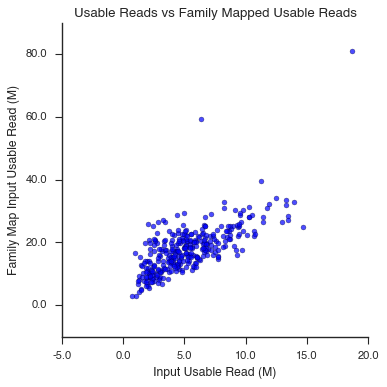

In [44]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.scatter(input_df.input_usable, input_df.family_map_input_usable, alpha=.7)
    ax.set_xlabel("Input Usable Read (M)")
    ax.set_ylabel("Family Map Input Usable Read (M)")
    ax.set_title("Usable Reads vs Family Mapped Usable Reads")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)

    sns.despine(ax=ax)

In [45]:
scipy.stats.linregress(input_df.input_usable, input_df.family_map_input_usable)

LinregressResult(slope=1.8847447861477551, intercept=7988537.9453541134, rvalue=0.71169272501201286, pvalue=8.9189907523662018e-52, stderr=0.10319509298250441)

Input reads don't aren't a problem, very few under a million, the ones that are get rescued by family mapping sanely

In [46]:
merged_data = merged_data.set_index(['uID', 'RBP', 'Cell line', 'rep'])

# Paper Quality Figures for Read Losses

In [82]:
nicely_formatted_reads = merged_data[['Input Reads', 'Reads Written Round 2', 'uncollapsed', 'unique', 'unique_genome_nonrep']]
nicely_formatted_reads = nicely_formatted_reads.div(nicely_formatted_reads['Input Reads'],axis=0)
nicely_formatted_reads_violin = nicely_formatted_reads.reset_index()[['Reads Written Round 2', 'uncollapsed', 'unique', 'unique_genome_nonrep']].unstack().reset_index()

In [49]:
labels = ['Trimmed', 'Mapped (Repetitive + Unique)', 'PCR Duplicate Removed', 'Unique Genomic Reads']

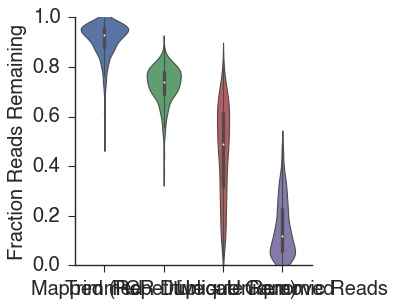

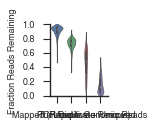

In [50]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_presentation.svg"), figsize=(5.0 * num_cols,4.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="CLIP",
                   data=nicely_formatted_reads_violin, 
                   orient='v', 
                   linewidth=1,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=18)
    ax.set_xticklabels(labels, fontsize=18)

num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_paper.svg"), figsize=(2.0 * num_cols, 1.6*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="CLIP", data=nicely_formatted_reads_violin, 
                   orient='v', 
                   linewidth=.5,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=8)
    ax.set_xticklabels(labels, fontsize=8)


In [51]:
nicely_formatted_input_reads = input_reads[['Input Reads', 'Reads Written Round 2', 'input_reads', 'usable', 'unique_genome_nonrep']]
nicely_formatted_input_reads = nicely_formatted_input_reads.div(nicely_formatted_input_reads['Input Reads'],axis=0)
nicely_formatted_input_reads_violin = nicely_formatted_input_reads.reset_index()[['Reads Written Round 2', 'input_reads', 'usable', 'unique_genome_nonrep']].unstack().reset_index()

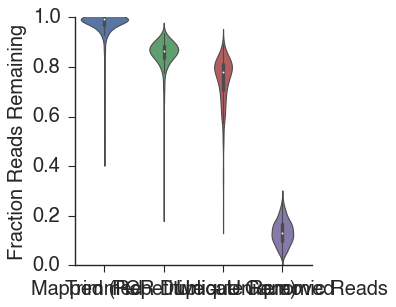

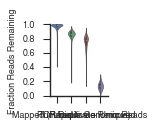

In [52]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_input_presentation.svg"), figsize=(5.0 * num_cols,4.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="level_0", 
                   data=nicely_formatted_input_reads_violin, 
                   orient='v', 
                   linewidth=1,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=18)
    ax.set_xticklabels(labels, fontsize=18)

num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_input_paper.svg"), figsize=(2.0 * num_cols, 1.6*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="level_0", data=nicely_formatted_input_reads_violin, 
                   orient='v', 
                   linewidth=.5,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=8)
    ax.set_xticklabels(labels, fontsize=8)


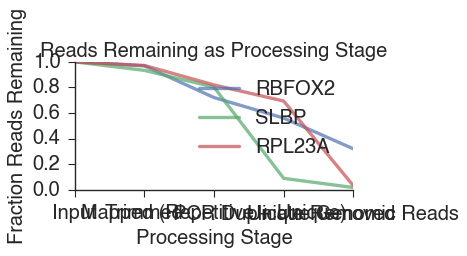

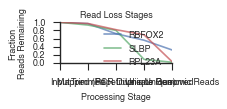

In [53]:
num_rows = 1.5 
num_cols = 1.5
with dataviz.Figure(os.path.join(img_dir, "read_loss_ideogram_presentation.svg"), figsize=(4.0 * num_cols,2.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    x_values = np.arange(0,5)
    ax.plot(x_values, nicely_formatted_reads.ix['204', 'RBFOX2', 'HepG2', 'rep1'].values, 
            label="RBFOX2",
           alpha=.7,
           linewidth=3)
    ax.plot(x_values, nicely_formatted_reads.ix['262', 'SLBP', 'K562', 'rep1'].values, 
            label="SLBP",
           alpha=.7,
           linewidth=3)
    ax.plot(x_values, nicely_formatted_reads.ix['613', 'RPL23A', 'K562', 'rep2'].values, 
            label="RPL23A",
           alpha=.7,
           linewidth=3)

    sns.despine(ax=ax)
    ax.set_ylabel("Fraction Reads Remaining", fontsize=18)
    ax.set_xlabel("Processing Stage", fontsize=18)
    ax.set_xticks(x_values)
    ax.set_xticklabels( ['Input', 'Trimmed', 'Mapped (Repetitive + Unique)', 'PCR Duplicate Removed', 'Unique Genomic Reads'], fontsize=18)
    ax.set_title("Reads Remaining as Processing Stage", fontsize=18)
    ax.set_ylim(0,1)
    ax.legend(fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

num_rows = 1.5 
num_cols = 1.5
with dataviz.Figure(os.path.join(img_dir, "read_loss_ideogram_paper.svg"), figsize=(2 * num_cols,1*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    x_values = np.arange(0,5)
    ax.plot(x_values, nicely_formatted_reads.ix['204', 'RBFOX2', 'HepG2', 'rep1'].values, 
            label="RBFOX2",
           alpha=.7,
           linewidth=1.5)
    ax.plot(x_values, nicely_formatted_reads.ix['262', 'SLBP', 'K562', 'rep1'].values, 
            label="SLBP",
           alpha=.7,
           linewidth=1.5)
    ax.plot(x_values, nicely_formatted_reads.ix['613', 'RPL23A', 'K562', 'rep2'].values, 
            label="RPL23A",
           alpha=.7,
           linewidth=1.5)

    sns.despine(ax=ax)
    ax.set_ylabel("Fraction\nReads Remaining", fontsize=8)
    ax.set_xlabel("Processing Stage", fontsize=8)
    ax.set_xticks(x_values)
    ax.set_xticklabels( ['Input', 'Trimmed', 'Mapped (Repetitive + Unique)', 'PCR Duplicate Removed', 'Unique Genomic Reads'], fontsize=18)
    ax.set_title("Read Loss Stages", fontsize=8)
    ax.set_ylim(0,1)
    ax.legend(fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


# Get read loss numbers for my pipeline only

In [99]:
cols_of_interest = ['Input Reads', 'Reads Written Round 2', 'Reads Passing Quality Filter', 'Uniquely Mapped Reads', 'Usable Reads']
nicely_formatted_reads = merged_data[cols_of_interest]
nicely_formatted_reads_fraction = nicely_formatted_reads.div(nicely_formatted_reads['Input Reads'],axis=0)
nicely_formatted_reads_violin = nicely_formatted_reads_fraction.reset_index()[cols_of_interest].unstack().reset_index()

In [132]:
nicely_formatted_reads_percent_lost = {}
for col_1, col_2 in zip(cols_of_interest, cols_of_interest[1:]):
    print col_2, " and ", col_1
    nicely_formatted_reads_percent_lost[col_2] = 1 - (nicely_formatted_reads[col_2] / nicely_formatted_reads[col_1])

Reads Written Round 2  and  Input Reads
Reads Passing Quality Filter  and  Reads Written Round 2
Uniquely Mapped Reads  and  Reads Passing Quality Filter
Usable Reads  and  Uniquely Mapped Reads


In [127]:
nicely_formatted_reads_percent_lost = pd.DataFrame(nicely_formatted_reads_percent_lost)
nicely_formatted_reads_percent_lost = nicely_formatted_reads_percent_lost[cols_of_interest[1:]]
nicely_formatted_reads_percent_lost = nicely_formatted_reads_percent_lost.reset_index()[cols_of_interest[1:]].unstack().reset_index()

In [128]:
labels = ['Input', 'Trimmed', 'Rep Elements Removed', 'Mapped', 'Unique Genomic Reads']

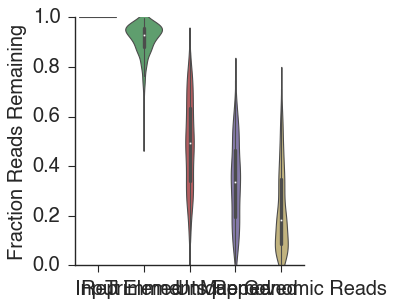

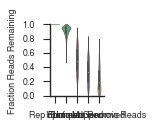

In [129]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_presentation.svg"), figsize=(5.0 * num_cols,4.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="CLIP",
                   data=nicely_formatted_reads_violin, 
                   orient='v', 
                   linewidth=1,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=18)
    ax.set_xticklabels(labels, fontsize=18)

num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_paper.svg"), figsize=(2.0 * num_cols, 1.6*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="CLIP", data=nicely_formatted_reads_violin, 
                   orient='v', 
                   linewidth=.5,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Remaining", fontsize=8)
    ax.set_xticklabels(labels, fontsize=8)


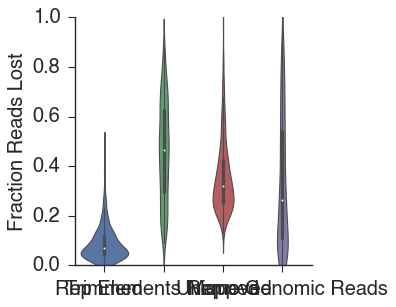

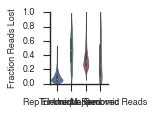

In [130]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_presentation.svg"), figsize=(5.0 * num_cols,4.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="level_0",
                   data=nicely_formatted_reads_percent_lost, 
                   orient='v', 
                   linewidth=1,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Lost", fontsize=18)
    ax.set_xticklabels(labels[1:], fontsize=18)

num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "read_loss_fraction_paper.svg"), figsize=(2.0 * num_cols, 1.6*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.violinplot(y=0, x="level_0", data=nicely_formatted_reads_percent_lost, 
                   orient='v', 
                   linewidth=.5,
                   ax=ax)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.set_xlabel("")
    ax.set_ylabel("Fraction Reads Lost", fontsize=8)
    ax.set_xticklabels(labels[1:], fontsize=8)


# Numbers for data processing section

In [54]:
processed_cols = """uncollapsed
directional
unique
Input Reads
Reads Written
repetitive_count
Reads Passing Quality Filter
Uniquely Mapped Reads
Number of reads mapped to too many loci
Usable Reads
Fraction Collapsed
Fraction Usable
Reads Written Round 2
unique_family_mapped_reads
fraction_repetitive
input_usable
family_map_input_usable
input_reads
usable
unique_genome_nonrep
lost_due_to_rep_mapping""".split("\n")


In [57]:
merged_data['lost_due_to_rep_mapping'] = merged_data['Reads Written Round 2'] - merged_data['Reads Passing Quality Filter']
stats_data = merged_data[processed_cols].copy()


In [58]:
rpl_rbp = stats_data.ix['613', 'RPL23A', 'K562', 'rep2'] 

In [59]:
#mean reads lost due to repetitive elements
(rpl_rbp['lost_due_to_rep_mapping'] / rpl_rbp['Input Reads'])

0.82011091483137422

In [60]:
stats_data = stats_data.reset_index()

In [61]:
#mean reads lost due to repetitive elements
(stats_data['lost_due_to_rep_mapping'] / stats_data['Input Reads']).mean()

0.42255633569153633

In [63]:
for x in merged_data.columns:
    print x

CLIP

INPUT
Submitted Date
annotation
family
family_bound
family_mapping_submitable
is_qced
note
notes
peaks_submitable
reference
submitted
generally_submittable
input_norm
uncollapsed
directional
unique
full_name
Input Reads
Reads Written
repetitive_count
Reads Passing Quality Filter
Uniquely Mapped Reads
Number of reads mapped to too many loci
Usable Reads
Fraction Collapsed
Fraction Usable
Reads Written Round 2
full_file_name
unique_family_mapped_reads
fraction_repetitive
input_file_name
input_usable
input_name
family_map_input_usable
input_reads
usable
unique_genome_nonrep
lost_due_to_rep_mapping


In [66]:
foo = nicely_formatted_input_reads_violin.groupby("level_0").mean()
1 - foo[0]

level_0
Reads Written Round 2    0.027631
input_reads              0.148514
unique_genome_nonrep     0.865770
usable                   0.251861
Name: 0, dtype: float64

# How many mapped reads are lost if we don't adapter trim

In [67]:
from gscripts.general import parsers
import glob 

In [68]:
foo = merged_data[merged_data.submitted]

In [69]:
len(foo)

362

In [70]:
len(foo[(foo['Uniquely Mapped Reads'] / foo['Input Reads']) > .50])

82

In [73]:
#RBFOX2 %reads if we do adapter trim
(merged_data['Uniquely Mapped Reads'] / merged_data['Input Reads']).ix['204'].mean()

0.53197171838631974

In [74]:
(merged_data['Uniquely Mapped Reads'] / merged_data['Input Reads']).mean()

0.33367746926503195

In [75]:
analysis_dir = "/projects/ps-yeolab3/encode/analysis/encode_just_map_v13"
num_seps = 2
sep = "."

star_files = glob.glob(os.path.join(analysis_dir, "*rmRep.bamLog.final.out"))
star_names = parsers.get_names(star_files, num_seps, sep) 

rmRep_mapping_files = glob.glob(os.path.join(analysis_dir, "*.rep.bamLog.final.out"))
rmRep_mapping_names = parsers.get_names(rmRep_mapping_files, num_seps, sep)

star_df = pd.DataFrame({name: parsers.parse_star_file(star_file) for name, star_file in star_names.items()}).transpose()

rmRep_mapping_df = pd.DataFrame({name: parsers.parse_star_file(star_file) for name, star_file in rmRep_mapping_names.items()}).transpose()
rmRep_mapping_df.columns = ["{} rmRep".format(col) for col in rmRep_mapping_df.columns]

In [77]:
#RBFOX2 reads if we don't adapter trim
combined_df = pd.merge(star_df, rmRep_mapping_df, left_index=True, right_index=True, how="outer")
combined_df = combined_df[combined_df['Number of input reads rmRep'] != 0]


#Got my numbers from here, manually inputed them
combined_df[['Number of input reads rmRep', 'Uniquely mapped reads number']].ix[['RBFOX2-204-CLIP_S1_R1.A01_204_01_RBFOX2',
                                                                              'RBFOX2-204-CLIP_S1_R1.B06_204_01_RBFOX2',
                                                                              'RBFOX2-204-CLIP_S1_R1.C01_204_02_RBFOX2',
                                                                              'RBFOX2-204-CLIP_S1_R1.D08fixed_204_02_RBFOX2']]

,Number of input reads rmRep,Uniquely mapped reads number
RBFOX2-204-CLIP_S1_R1.A01_204_01_RBFOX2,4915467,1690348
RBFOX2-204-CLIP_S1_R1.B06_204_01_RBFOX2,5123391,1824856
RBFOX2-204-CLIP_S1_R1.C01_204_02_RBFOX2,4270978,1471108
RBFOX2-204-CLIP_S1_R1.D08fixed_204_02_RBFOX2,5965950,2249519


In [78]:
rep1_mapped = (1690348 + 1824856)
rep2_mapped = (1471108 + 2249519)

rep1_input = (4915467. + 5123391)
rep2_input = (4270978. + 5965950)

print ((rep1_mapped / rep1_input) + (rep2_mapped / rep2_input)) / 2

0.356805632585


This might not be a fair comparison because I'm not taking into account reads we missed when removing repetitive elements, but I think its alright...